In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
import cv2
cv2.__version__

'4.5.5'

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('Online')
random_range = random.sample(range(len(all_classes_names)), 6)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'Online/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    
    video_reader = cv2.VideoCapture(f'Online/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

<Figure size 1440x1440 with 0 Axes>

In [5]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = 'Online'
CLASSES_LIST = all_classes_names

In [6]:
print(CLASSES_LIST)
print(type(all_classes_names))

['Engaged', 'Distracted', 'Taking_Notes', 'NA', 'Talking', 'Using_Phone']
<class 'list'>


In [7]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
        
    video_reader.release()
    return frames_list

In [8]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [9]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Engaged
Extracting Data of Class: Distracted
Extracting Data of Class: Taking_Notes
Extracting Data of Class: NA
Extracting Data of Class: Talking
Extracting Data of Class: Using_Phone


In [10]:
one_hot_encoded_labels = to_categorical(labels)

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [12]:
def create_convlstm_model():

    model = Sequential()
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    model.summary()
    
    return model

In [13]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")

2023-07-13 15:01:54.291917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 15:01:54.316163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 15:01:54.316969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 15:01:54.318511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

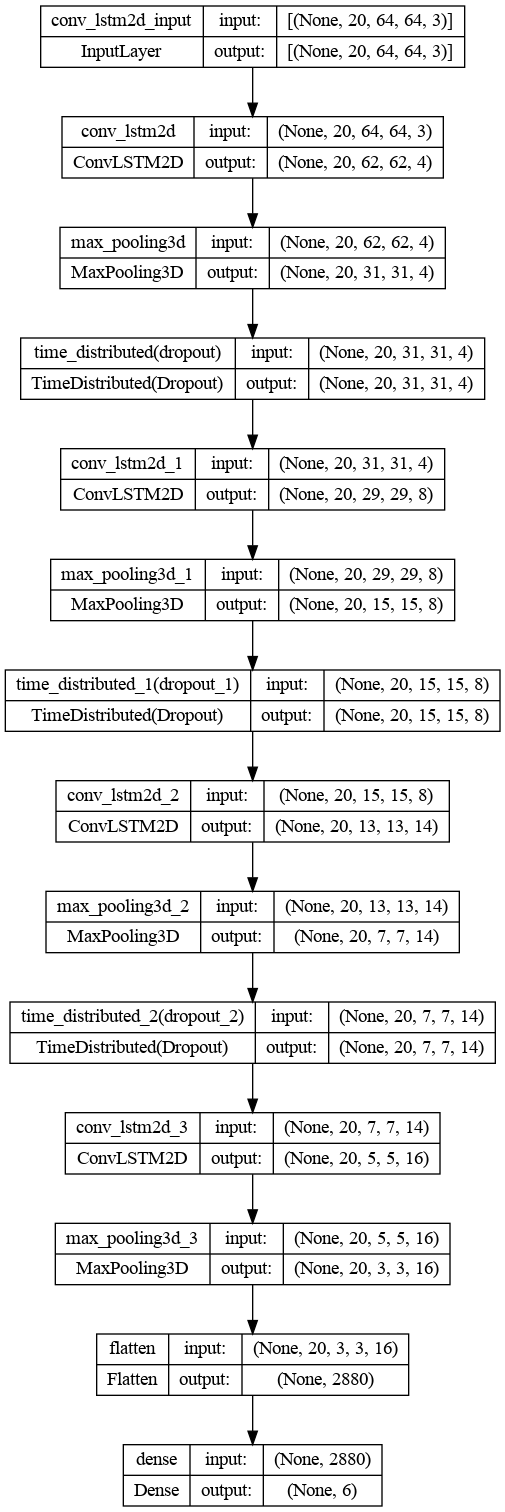

In [14]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [15]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/50


2023-07-13 15:02:05.974613: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/convolution_6' -> 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/add_4', 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/mul_6' -> 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/add_5', 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/clip_by_value' -> 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/mul_7', 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/clip_by_value_2' -> 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/mul_9', 'sequential/conv_lstm2d_2/while/body/_447/sequential/conv_lstm2d_2/while/clip_by_value_2' -> 'sequential/conv_lstm2d_

189/189 [==============================] - 27s 116ms/step - loss: 1.5186 - accuracy: 0.3003 - val_loss: 1.4042 - val_accuracy: 0.2857
Epoch 2/50
189/189 [==============================] - 21s 113ms/step - loss: 1.4225 - accuracy: 0.3439 - val_loss: 1.3992 - val_accuracy: 0.3386
Epoch 3/50
189/189 [==============================] - 22s 115ms/step - loss: 1.3746 - accuracy: 0.3955 - val_loss: 1.3791 - val_accuracy: 0.4021
Epoch 4/50
189/189 [==============================] - 21s 113ms/step - loss: 1.3045 - accuracy: 0.4405 - val_loss: 1.3245 - val_accuracy: 0.4497
Epoch 5/50
189/189 [==============================] - 22s 116ms/step - loss: 1.2234 - accuracy: 0.4987 - val_loss: 1.3647 - val_accuracy: 0.4497
Epoch 6/50
189/189 [==============================] - 21s 113ms/step - loss: 1.1740 - accuracy: 0.5357 - val_loss: 1.1955 - val_accuracy: 0.4815
Epoch 7/50
189/189 [==============================] - 21s 113ms/step - loss: 1.0347 - accuracy: 0.5886 - val_loss: 1.2193 - val_accuracy: 0.5

In [16]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

10/10 [==============================] - 0s 37ms/step - loss: 1.1800 - accuracy: 0.5619


In [17]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

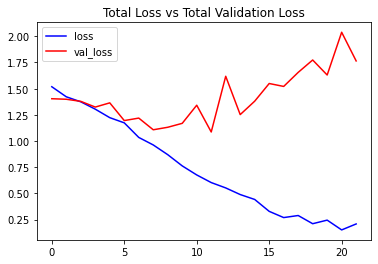

In [19]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

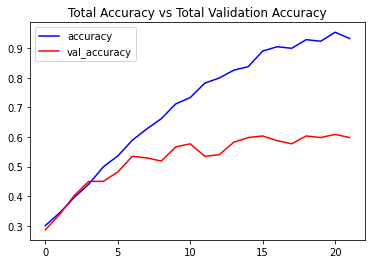

In [20]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 